In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline
sns.set(color_codes=True)

from transformers import BertTokenizer,BertForSequenceClassification,AdamW

In [2]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1', header = None)
df.columns=['Sentiment', 'id', 'Date', 'Query', 'User', 'Tweet']
df = df.drop(columns=['id', 'Date', 'Query', 'User'], axis=1)

In [3]:
df.head()

,Sentiment,Tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [4]:
df['Sentiment'] = df.Sentiment.replace(4,1)

/home/19aag9/ENTER/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/19aag9/ENTER/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/19aag9/ENTER/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


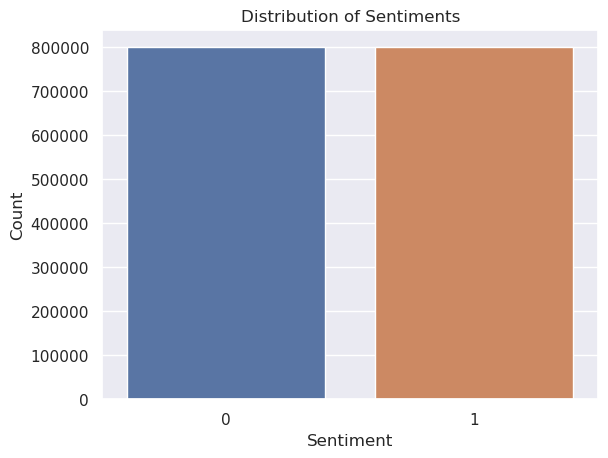

In [5]:
sentiment_counts = df['Sentiment'].value_counts()

sns.countplot(x='Sentiment', data=df)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [6]:
import re

hashtags = re.compile(r"^#\S+|\s#\S+")
mentions = re.compile(r"^@\S+|\s@\S+")
urls = re.compile(r"https?://\S+")

def process_text(text):
    text = re.sub(r'http\S+', '', text)
    text = hashtags.sub(' hashtag', text)
    text = mentions.sub(' entity', text)
    return text.strip().lower()

df['Tweet'] = df.Tweet.apply(process_text)

In [7]:
df.head()

,Sentiment,Tweet
0,0,"entity - awww, that's a bummer. you shoulda ..."
1,0,is upset that he can't update his facebook by ...
2,0,entity i dived many times for the ball. manage...
3,0,my whole body feels itchy and like its on fire
4,0,"entity no, it's not behaving at all. i'm mad. ..."


In [8]:
labels = df.Sentiment.values
text = df.Tweet.values

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case = True)

input_ids = []
attention_mask = []
for i in text:
    encoded_data = tokenizer.encode_plus(
    i,
    add_special_tokens=True,
    max_length=64,
    pad_to_max_length = True,
    return_attention_mask= True,
    return_tensors='pt')
    input_ids.append(encoded_data['input_ids'])
    attention_mask.append(encoded_data['attention_mask'])
input_ids = torch.cat(input_ids,dim=0)
attention_mask = torch.cat(attention_mask,dim=0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/19aag9/ENTER/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [11]:
from torch.utils.data import DataLoader,SequentialSampler,RandomSampler,TensorDataset,random_split

In [12]:
dataset = TensorDataset(input_ids,attention_mask,labels)
train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size

train_dataset,val_dataset = random_split(dataset,[train_size,val_size])

print('Training Size - ',train_size)
print('Validation Size - ',val_size)

train_dl = DataLoader(train_dataset,sampler = RandomSampler(train_dataset),
                     batch_size = 32)
val_dl = DataLoader(val_dataset,sampler = SequentialSampler(val_dataset),
                     batch_size = 32)



Training Size -  1280000
Validation Size -  320000


In [13]:
model = BertForSequenceClassification.from_pretrained(
'bert-base-uncased',
num_labels = 2,
output_attentions = False,
output_hidden_states = False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [14]:
optimizer = AdamW(model.parameters(),lr = 2e-5,eps=1e-8)

from transformers import get_linear_schedule_with_warmup
epochs = 1
total_steps = len(train_dl)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,
                                           num_training_steps=total_steps)

/home/19aag9/ENTER/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

sns.set(color_codes=True)

In [18]:
def evaluate(dataloader_test):
    model.eval()
    loss_val_total = 0
    predictions,true_vals = [],[]
    for batch in dataloader_test:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids':batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        with torch.no_grad():
            outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    loss_val_avg = loss_val_total / len(dataloader_test)
    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals,axis=0)
    return loss_val_avg,predictions,true_vals

In [19]:
from tqdm.notebook import tqdm
torch.cuda.empty_cache()
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(train_dl, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(train_dl)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_labels = evaluate(val_dl)
    tqdm.write(f'Validation loss: {val_loss}')


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/40000 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.32283713571392
Validation loss: 0.2958840841140598


In [32]:
output_dir = './'
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./tokenizer_config.json',
 './special_tokens_map.json',
 './vocab.txt',
 './added_tokens.json')

In [20]:
predicted_labels = np.argmax(predictions, axis=1)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')
conf_mat = confusion_matrix(true_labels, predicted_labels)

In [44]:
print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1 Score: {:.4f}'.format(f1))

Accuracy: 0.8739
Precision: 0.8788
Recall: 0.8675
F1 Score: 0.8732


In [27]:
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Classification Report
print("\nClassification Report:\n")
print(classification_report(true_labels, predicted_labels, target_names=['Negative', 'Positive']))


Classification Report:

              precision    recall  f1-score   support

    Negative       0.87      0.88      0.87    159855
    Positive       0.88      0.87      0.87    160145

    accuracy                           0.87    320000
   macro avg       0.87      0.87      0.87    320000
weighted avg       0.87      0.87      0.87    320000



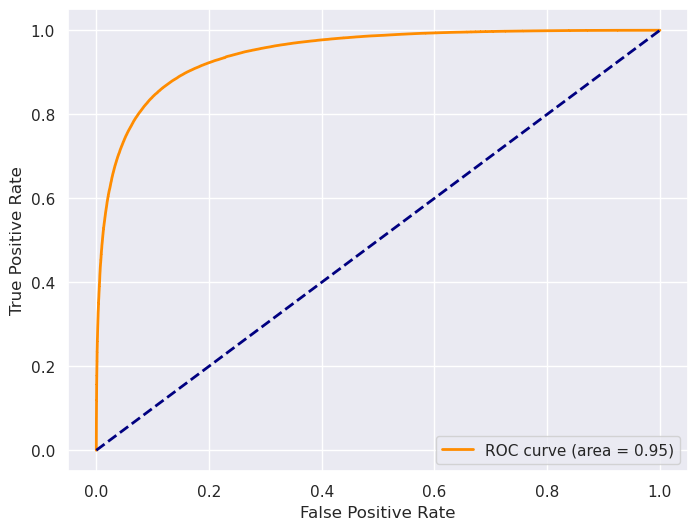

In [40]:
# ROC-AUC Score and Curve
roc_auc = roc_auc_score(true_labels, predictions[:, 1])
fpr, tpr, _ = roc_curve(true_labels, predictions[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

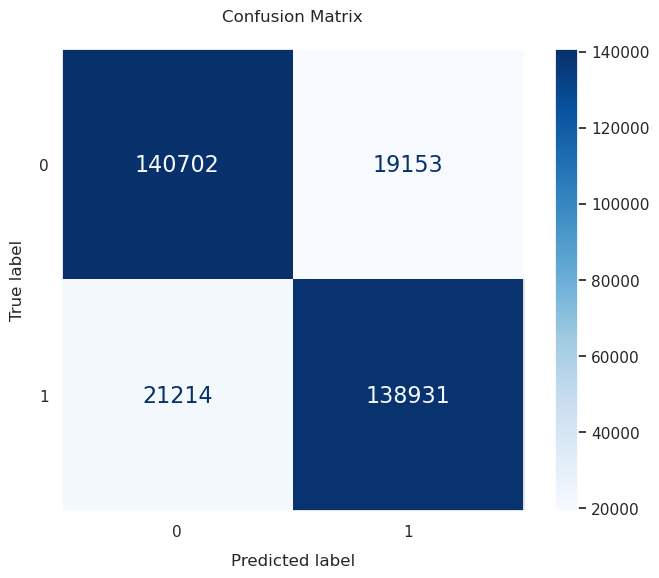

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(8, 6))


ax.set_title('Confusion Matrix', pad=20)  
ax.set_xlabel('Predicted Label', labelpad=10)  
ax.set_ylabel('True Label', labelpad=10)
ax.grid(False)
disp.plot(cmap='Blues', ax=ax, colorbar=True)
plt.show()


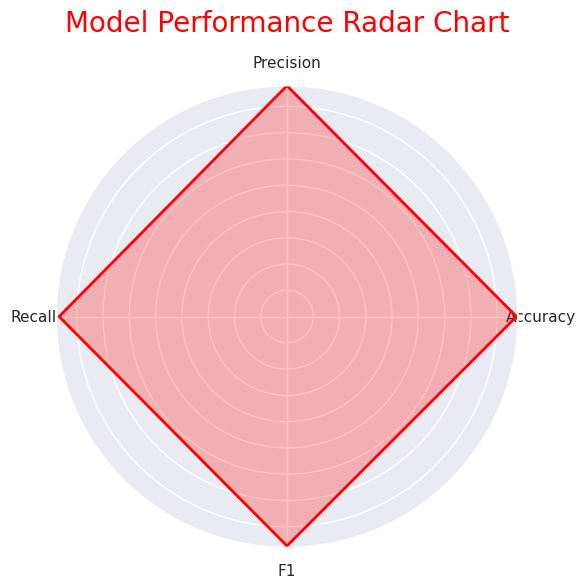

In [24]:
# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')
conf_mat = confusion_matrix(true_labels, predicted_labels)

# Radar Chart for Accuracy, Precision, Recall, and F1 Score
labels=np.array(['Accuracy', 'Precision', 'Recall', 'F1'])
stats=np.array([accuracy, precision, recall, f1])

angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
stats=np.concatenate((stats,[stats[0]]))
angles+=angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, stats, color='red', alpha=0.25)
ax.plot(angles, stats, color='red', linewidth=2)
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

plt.title('Model Performance Radar Chart', size=20, color='red', y=1.1)
plt.show()


In [119]:
count = 0
for ind, num in enumerate(predicted_labels):
    if num != true_labels[ind]:
        print('Tweet: ', text[ind])
        print('Predicted Sentiment: ', predicted_labels[ind])
        print('Actual Sentiment: ', true_labels[ind])
        count += 1
        if count == 5:
            break

Tweet:  entity ahh ive always wanted to see rent  love the soundtrack!!
Predicted Sentiment:  0
Actual Sentiment:  1
Tweet:  thought sleeping in was an option tomorrow but realizing that it now is not. evaluations in the morning and work in the afternoon!
Predicted Sentiment:  1
Actual Sentiment:  0
Tweet:  really don't feel like getting up today... but got to study to for tomorrows practical exam...
Predicted Sentiment:  0
Actual Sentiment:  1
Tweet:  ugh....92 degrees tomorrow
Predicted Sentiment:  0
Actual Sentiment:  1
Tweet:  where did u move to?  i thought u were already in sd. ?? hmmm. random u found me. glad to hear yer doing well.
Predicted Sentiment:  1
Actual Sentiment:  0


In [50]:
for i in range(5):
    print('Tweet: ', text[i])
    print('Predicted Sentiment: ', predicted_labels[i])
    print('Actual Sentiment: ', true_labels[i])
    print()

Tweet:  entity  - awww, that's a bummer.  you shoulda got david carr of third day to do it. ;d
Predicted Sentiment:  0
Actual Sentiment:  0

Tweet:  is upset that he can't update his facebook by texting it... and might cry as a result  school today also. blah!
Predicted Sentiment:  0
Actual Sentiment:  0

Tweet:  entity i dived many times for the ball. managed to save 50%  the rest go out of bounds
Predicted Sentiment:  1
Actual Sentiment:  1

Tweet:  my whole body feels itchy and like its on fire
Predicted Sentiment:  1
Actual Sentiment:  1

Tweet:  entity no, it's not behaving at all. i'm mad. why am i here? because i can't see you all over there.
Predicted Sentiment:  0
Actual Sentiment:  0



In [35]:
from transformers import BertTokenizer,BertForSequenceClassification
import torch
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
output_dir = './'
tokenizer = BertTokenizer.from_pretrained(output_dir)
model_loaded = BertForSequenceClassification.from_pretrained(output_dir)

Loading BERT tokenizer...


In [36]:
def Sentiment(sent):
    output_dir = './'
    tokenizer = BertTokenizer.from_pretrained(output_dir)
    model_loaded = BertForSequenceClassification.from_pretrained(output_dir)
    encoded_dict = tokenizer.encode_plus(
                        sent, 
                        add_special_tokens = True,
                        max_length = 64,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
        
    input_id = encoded_dict['input_ids']

    attention_mask = encoded_dict['attention_mask']
    input_id = torch.LongTensor(input_id)
    attention_mask = torch.LongTensor(attention_mask)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_loaded = model_loaded.to(device)
    input_id = input_id.to(device)
    attention_mask = attention_mask.to(device)

    with torch.no_grad():
        outputs = model_loaded(input_id, token_type_ids=None, attention_mask=attention_mask)

    logits = outputs[0]
    index = logits.argmax()
    return index

In [38]:
ans = Sentiment('i want to die')

if ans == 1:
    print("Positive")
else:
    print("Negative")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Negative


In [39]:
ans = Sentiment('i have never been happier')

if ans == 1:
    print("Positive")
else:
    print("Negative")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Positive
